# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [14]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [15]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

start_datetime = datetime.datetime.strptime("2024-12-31 00:00:00", "%Y-%m-%d %H:%M:%S")
end_datetime = datetime.datetime.strptime("2023-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
target_coin = "FX_BTC_JPY"


ohlc_list=[]
while start_datetime > end_datetime:
    unixtime = start_datetime.timestamp() * 1000
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    start_datetime -= timedelta(minutes=720)
    time.sleep(1)


df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)
display(df_1m)

df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

,op,hi,lo,cl,volume,volume_buy_sum,volume_sell_sum,volume_buy,volume_sell
timestamp,,,,,,,,,
2023-01-01 00:01:00+00:00,2167713.0,2167866.0,2167500.0,2167614.0,0.699850,213.791319,341.176945,0.115850,0.584000
2023-01-01 00:02:00+00:00,2167656.0,2167656.0,2166669.0,2166709.0,1.731984,212.290279,318.156367,0.973284,0.758700
2023-01-01 00:03:00+00:00,2166835.0,2167077.0,2166200.0,2166498.0,2.159115,212.648850,338.061730,1.394015,0.765100
2023-01-01 00:04:00+00:00,2166666.0,2166888.0,2165879.0,2166707.0,1.895298,211.138406,315.376904,0.794917,1.100382
2023-01-01 00:05:00+00:00,2166714.0,2167173.0,2166361.0,2167173.0,0.595100,210.168098,337.285061,0.367700,0.227400
...,...,...,...,...,...,...,...,...,...
2024-12-30 23:56:00+00:00,14578469.0,14588152.0,14575000.0,14588152.0,2.231343,93.860988,87.847157,0.876143,1.355200
2024-12-30 23:57:00+00:00,14585739.0,14586743.0,14581296.0,14581296.0,0.206300,93.229632,89.464083,0.206300,0.000000
2024-12-30 23:58:00+00:00,14584290.0,14587358.0,14573539.0,14577488.0,1.290390,92.674333,87.734476,0.366390,0.924000


1分足のOHLCVを15分足に変換します。

In [16]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2023-01-01 00:00:00+00:00,2167713.0,2167866.0,2165879.0,2166501.0,21.367880
2023-01-01 00:15:00+00:00,2166401.0,2169418.0,2166391.0,2169284.0,40.963142
2023-01-01 00:30:00+00:00,2169384.0,2169384.0,2164100.0,2166137.0,23.306142
2023-01-01 00:45:00+00:00,2166086.0,2167787.0,2165801.0,2166609.0,9.301008
2023-01-01 01:00:00+00:00,2166641.0,2168282.0,2166241.0,2167848.0,14.135462
...,...,...,...,...,...
2024-12-30 23:00:00+00:00,14570613.0,14570613.0,14501068.0,14533407.0,25.337718
2024-12-30 23:15:00+00:00,14530713.0,14557851.0,14504073.0,14557851.0,10.473942
2024-12-30 23:30:00+00:00,14560486.0,14585000.0,14542969.0,14576975.0,19.153414


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [17]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2023-01-01 00:00:00+00:00,2167713.0,2167866.0,2165879.0,2166501.0,21.367880,0.0
2023-01-01 00:15:00+00:00,2166401.0,2169418.0,2166391.0,2169284.0,40.963142,0.0
2023-01-01 00:30:00+00:00,2169384.0,2169384.0,2164100.0,2166137.0,23.306142,0.0
2023-01-01 00:45:00+00:00,2166086.0,2167787.0,2165801.0,2166609.0,9.301008,0.0
2023-01-01 01:00:00+00:00,2166641.0,2168282.0,2166241.0,2167848.0,14.135462,0.0
...,...,...,...,...,...,...
2024-12-30 23:00:00+00:00,14570613.0,14570613.0,14501068.0,14533407.0,25.337718,0.0
2024-12-30 23:15:00+00:00,14530713.0,14557851.0,14504073.0,14557851.0,10.473942,0.0
2024-12-30 23:30:00+00:00,14560486.0,14585000.0,14542969.0,14576975.0,19.153414,0.0


## 特徴量エンジニアリング

In [18]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_bf_fx_features.pkl')

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,2167713.0,2167866.0,2165879.0,2166501.0,21.367880,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:15:00+00:00,2166401.0,2169418.0,2166391.0,2169284.0,40.963142,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:30:00+00:00,2169384.0,2169384.0,2164100.0,2166137.0,23.306142,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:45:00+00:00,2166086.0,2167787.0,2165801.0,2166609.0,9.301008,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00+00:00,2166641.0,2168282.0,2166241.0,2167848.0,14.135462,0.0,2329.827206,14.3,-2301.227206,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1157.763603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:00:00+00:00,14570613.0,14570613.0,14501068.0,14533407.0,25.337718,0.0,62248.523898,15939.1,-30370.323898,96255.753777,...,-0.995508,-0.636981,0,1.104802,0.938666,-65196.514286,-89.998231,355825.657143,-32386.320879,23154.711949
2024-12-30 23:15:00+00:00,14530713.0,14557851.0,14504073.0,14557851.0,10.473942,0.0,67783.464956,26049.6,-15684.264956,89796.914409,...,-0.980552,-0.554580,0,1.136871,0.936349,-97412.885714,-89.998119,298578.171429,-30460.850549,20866.932478
2024-12-30 23:30:00+00:00,14560486.0,14585000.0,14542969.0,14576975.0,19.153414,0.0,38797.222642,1387.1,-36023.022642,48978.936713,...,-0.848158,-0.225153,0,1.051343,0.932922,-103235.200000,-89.997698,220267.342857,-24884.810989,18705.061321


## 学習に使う特徴量の定義

In [19]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


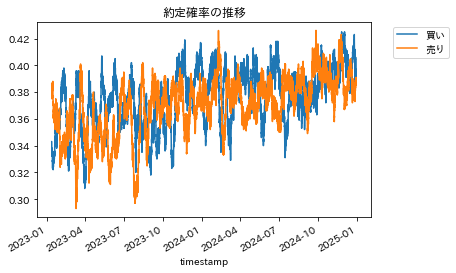

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


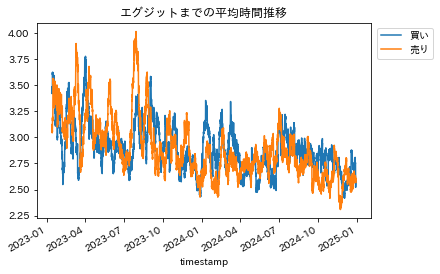

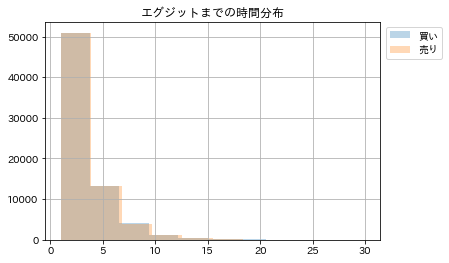

毎時刻、この執行方法でトレードした場合の累積リターン


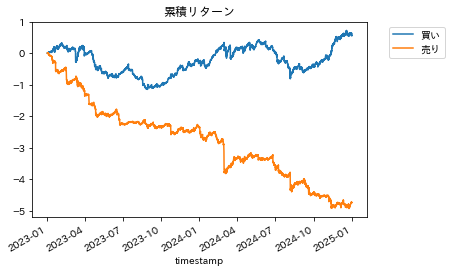

In [20]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


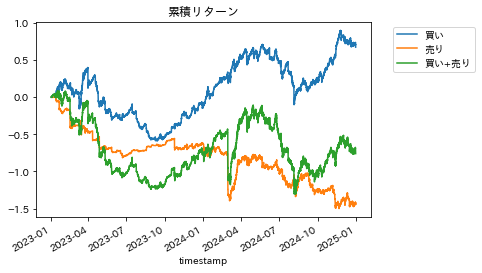

In [21]:
df = pd.read_pickle('df_bf_fx_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell_bffx.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_fit.pkl')

## バックテストと検定

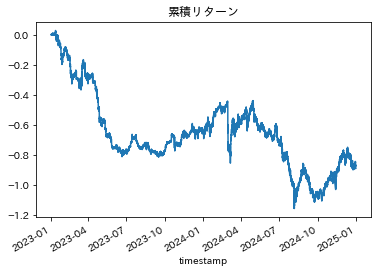

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


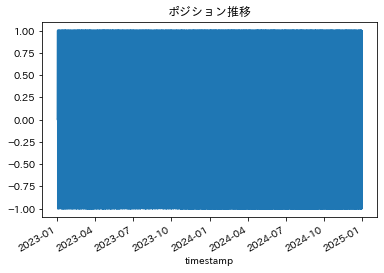

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


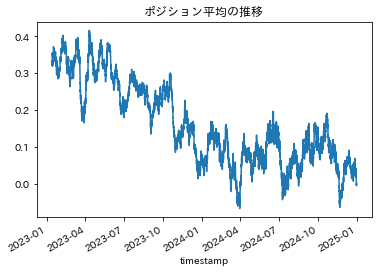

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


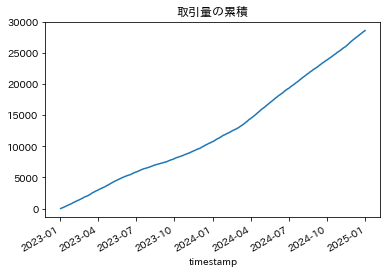

t検定
t値 -1.528268024462567
p値 0.12645053145325877
p平均法 n = 5
p平均 0.7738524947259013
エラー率 7.227027555656844


In [22]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [23]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [24]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-16 12:00:00+00:00,15459611.0,15510199.0,15439400.0,15501950.0,16.242577,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000107,0.000836,buy,sell
2025-01-16 12:15:00+00:00,15498810.0,15545470.0,15492652.0,15508400.0,22.113401,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000107,0.000836,buy,sell
2025-01-16 12:30:00+00:00,15507791.0,15556747.0,15506781.0,15533500.0,19.712990,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000107,0.000836,buy,sell
2025-01-16 12:45:00+00:00,15535559.0,15561038.0,15515734.0,15536801.0,16.054461,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000107,0.000836,buy,sell
2025-01-16 13:00:00+00:00,15539011.0,15546476.0,15463956.0,15473797.0,23.960996,51670.176996,5673.6,-40322.976996,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22998.288498,-0.001286,0.000764,none,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17 13:15:00+00:00,16021400.0,16037251.0,15985878.0,15993828.0,27.300357,40003.415821,2524.9,-34953.615821,13375.530927,-86090.841851,...,0.976715,28641.657143,89.990892,-53137.228571,6290.683516,18739.257910,0.000185,0.000037,buy,sell
2025-01-17 13:30:00+00:00,15994326.0,16040482.0,15969889.0,16028200.0,21.352546,45515.404566,16678.7,-12158.004566,26164.776411,-73084.335925,...,0.973806,-1374.000000,89.990225,-77574.000000,5861.538462,14418.352283,0.000044,-0.000111,buy,none
2025-01-17 13:45:00+00:00,16024401.0,16035399.0,15983574.0,15986601.0,10.270748,42444.188589,3838.1,-34767.988589,22265.998415,-73869.217478,...,0.973357,34674.571429,89.987668,-25724.142857,4646.054945,19303.044294,0.000103,0.000019,buy,sell


N/A
